## Cat vs Dog Classification

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers

### Loading the dataset

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [9]:
ds = train_ds.take(5)

,image,label
0,,1 (dog)
1,,1 (dog)
2,,1 (dog)
3,,0 (cat)

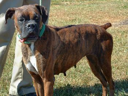
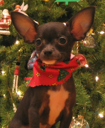
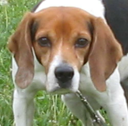
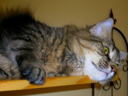

In [10]:
tfds.as_dataframe(ds.take(4),metadata)

In [11]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

2


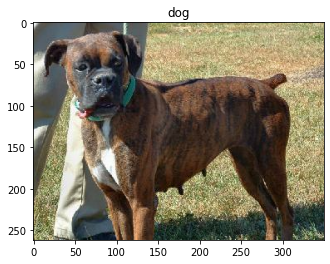

In [12]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [13]:
IMG_SIZE = 180

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

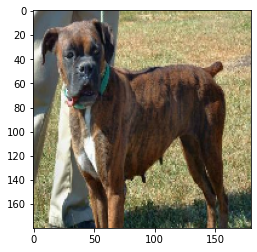

In [15]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

In [16]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 0.999922


In [17]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [18]:
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [19]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### Modelin Oluşturulması

In [20]:
model = tf.keras.Sequential([
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1,activation="sigmoid")
])

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Modelin Eğitilmesi

In [22]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
291/291 [==============================] - 66s 210ms/step - loss: 0.6143 - accuracy: 0.6511 - val_loss: 0.5680 - val_accuracy: 0.7003
Epoch 2/5
291/291 [==============================] - 60s 201ms/step - loss: 0.5095 - accuracy: 0.7513 - val_loss: 0.5805 - val_accuracy: 0.6814
Epoch 3/5
291/291 [==============================] - 60s 202ms/step - loss: 0.4351 - accuracy: 0.7984 - val_loss: 0.4718 - val_accuracy: 0.7846
Epoch 4/5
291/291 [==============================] - 60s 201ms/step - loss: 0.3717 - accuracy: 0.8321 - val_loss: 0.4685 - val_accuracy: 0.7837
Epoch 5/5
291/291 [==============================] - 60s 202ms/step - loss: 0.3013 - accuracy: 0.8716 - val_loss: 0.5082 - val_accuracy: 0.7928


In [23]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

37/37 [==============================] - 3s 81ms/step - loss: 0.4351 - accuracy: 0.8147
Accuracy 0.8147033452987671


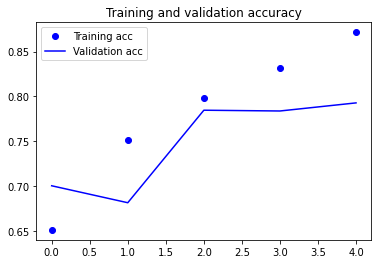

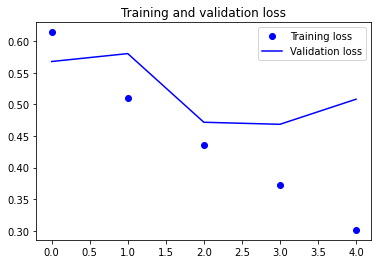

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
model.predict(test_ds)

array([[0.00403803],
       [0.31293067],
       [0.69449437],
       ...,
       [0.02704572],
       [0.93282914],
       [0.01965457]], dtype=float32)

### Modelin Kaydedilmesi

In [26]:
model.save("1.h5")